In [79]:
import os
from pathlib import Path
from typing import Tuple, List, Optional
os.chdir("/home/haok/MoE-Research")

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch import Tensor


In [80]:
def load(
    checkpoint_step: int,
    layer_number: int = 18,
    expert_index: int = 24,
    min_samples: int = 100,
    top_k: int = 5,
    indices: Optional[List[int]] = None,
) -> Tuple[Tensor, Tensor]:

    # Load the data in a safe fashion
    data = torch.load(f"results/expert-specialization/flame-moe-1.7b/{checkpoint_step}/{layer_number}-{expert_index}.pt")
    assert isinstance(data, tuple) and len(data) == 2
    assert isinstance(data[0], Tensor) and isinstance(data[1], Tensor)

    # Fraction of times this expert activates a given token
    sample_count, active_count = data
    specialization = torch.where(
        sample_count > 0,
        active_count.float() / sample_count.float(),
        torch.zeros_like(sample_count, dtype=torch.float)
    )

    # If desired, load those particular tokens
    if indices is not None:
        return specialization[[indices]], torch.Tensor(indices)

    # Mask out low-sample entries
    specialization = torch.where(
        sample_count >= min_samples,
        specialization,
        torch.tensor(float('-inf'))
    )

    pack = specialization.topk(k=top_k)
    return pack.values, pack.indices


In [120]:
alls = []

for expert_index in range(0, 4):
    top_k, min_samples = 3, 4
    layer_number = 9

    files = Path("results/expert-specialization/flame-moe-1.7b").glob(f"*/{layer_number}-{expert_index}.pt")
    steps = sorted([int(p.parent.name) for p in files])

    data = list()
    _, indices = load(steps[-1], top_k=top_k, min_samples=min_samples)

    for step in steps:
        spec, vals = load(step, indices=indices)
        data.append(spec.tolist())
    alls.append(data)

print(torch.tensor(alls).max())


tensor(0.7500)


In [126]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-12b")

token_id = 2671
token_text = tokenizer.decode(token_id)
print(f"Token ID {token_id} corresponds to: '{token_text}'")

token_id = 200
token_text = tokenizer.decode(token_id)
print(f"Token ID {token_id} corresponds to: '{token_text}'")

token_id = 190
token_text = tokenizer.decode(token_id)
print(f"Token ID {token_id} corresponds to: '{token_text}'")


Token ID 2671 corresponds to: 'vironment'
Token ID 200 corresponds to: ''
'oken ID 190 corresponds to: '


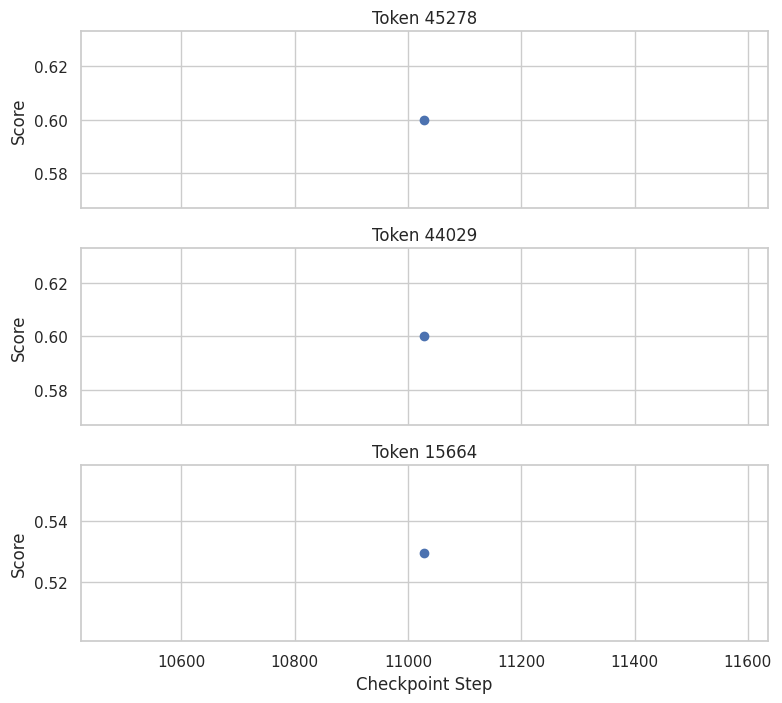

In [135]:
top_k, min_samples = 3, 5
layer_number, expert_index = 9, 0

files = Path("results/expert-specialization/flame-moe-1.7b").glob(f"*/{layer_number}-{expert_index}.pt")
steps = sorted([int(p.parent.name) for p in files])

data = list()
_, indices = load(steps[-1], top_k=top_k, min_samples=min_samples)

for step in steps:
    spec, _ = load(step, indices=indices)
    data.append(spec.tolist())

data = list(zip(*data))

fig, axes = plt.subplots(top_k, 1, figsize=(8, 2.4 * top_k), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(steps, data[i], marker='o')
    ax.set_ylabel("Score")
    ax.set_title(f"Token {indices[i].item()}")

axes[-1].set_xlabel("Checkpoint Step")
plt.tight_layout()
plt.show()
